In [1]:
using CSV, DataFrames, JuMP, Gurobi, StatsPlots, Random, XLSX

## Load in data

In [2]:
# Define sizes
#num_suppliers = 200 # i
#num_consumer_regions = 7 # j = c(i) 
#num_time = 10; # t 
#num_producer_regions = 5 # p(i)

# Parameters
# alpha
# delta

In [3]:
availability = CSV.read("availability.csv", DataFrame)
col_order = [1, 9, 8, 7, 6, 5, 4, 3, 2]
availability = availability[:, col_order]
availability = sort(availability, :Region);

In [4]:
demand = CSV.read("demand.csv", DataFrame)
replace!(demand.Region, "Europe, Middle East, and Africa" => "EMEA");

In [5]:
revenue = CSV.read("rev.csv", DataFrame)
replace!(revenue.Region, "Europe, Middle East, and Africa" => "EMEA")
rev_year = []
for i in 2:size(revenue)[2]
    col_sum = sum(revenue[:, i]) * 1e6
    append!(rev_year, col_sum)
end
rev_year = Array(rev_year);

In [6]:
holding_costs = CSV.read("inventory_holding_cost.csv", DataFrame)[:, 2:end]
holding_costs.inventory_costs_holding = holding_costs.inventory_costs_holding * 1e6;

In [7]:
shipping_costs = CSV.read("transport_costs.csv", DataFrame);

In [8]:
shipping_mapping = shipping_costs[:, 1:2]
shipping_mapping = hcat(DataFrame(Row_Count=1:nrow(shipping_mapping)), shipping_mapping)
shipping_mapping = combine(groupby(shipping_mapping, [:producer_region, :consumer_region])) do sub_df
    DataFrame(Value_mean = first(sub_df.Row_Count))
end
shipping_mapping = unstack(shipping_mapping, :consumer_region, :Value_mean)
shipping_mapping = sort(shipping_mapping, :producer_region)

Row,producer_region,Asia Pacific,Greater China,EMEA,North America,Latin America
,String15,Int64?,Int64?,Int64?,Int64?,Int64?
1,AMERICAS,5,10,15,20,25
2,EMEA,4,9,14,19,24
3,N ASIA,3,8,13,18,23
4,S ASIA,2,7,12,17,22
5,SE ASIA,1,6,11,16,21


In [9]:
production_costs = CSV.read("cost.csv", DataFrame)
replace!(production_costs.Region, "Europe, Middle East, and Africa" => "EMEA");

In [10]:
# Define sizes
num_suppliers = size(availability)[1] #i
num_consumer_regions = size(demand)[1] # j = c(i) 
num_time = size(availability)[2] - 1;  
num_producer_regions = size(availability)[1] # p(i)

5

### Set-up

In [11]:
# Sets
suppliers = 1:num_suppliers
consumer_regions = 1:num_consumer_regions
producer_regions = 1:num_producer_regions
years = 1:num_time
years_incl_zero = 0:num_time

0:8

In [12]:
# Parameters and input data
A = Matrix(availability[:, 2:end]) #5x8
D = Matrix(demand[:, 2:end]) #5x8
R = Array(rev_year) #8x1
H = Array(holding_costs[:, 2]) #8x1
T = Matrix(shipping_costs[:, 6:end]) #25x8
W = Matrix(shipping_mapping[:, 2:end]) #encodes the prodcuer/consumer region for T 5x5
C = Matrix(production_costs[:, 2:end]); #5x8

### Creating the model

In [13]:
# Define parameters (choose 1 value for now)
alpha = 1

1

In [28]:
function run_model(alpha, suppliers, consumer_regions, producer_regions, years, years_incl_zero, A, D, R, H, T, W, C)
    # Initialize model
    model = Model(Gurobi.Optimizer);

    # Decision variables
    # X_{i,t} = quantity of shoes produced by supplier i (in producer region p(i)) at time t
    # S_{i,j,t} = quantity of shoes sold to consumer region j at time t, that are produced by supplier i (in producer region p(i))
    # E_{i,t} = holding quantity of shoes by supplier i (in producer region p(i)) at time t
    # M_{i,t} = marginal cost of getting supplier i to produce shoes at time t
    @variable(model, X[suppliers, years_incl_zero] >= 0);
    @variable(model, S[suppliers, consumer_regions, years] >= 0);
    @variable(model, E[suppliers, years_incl_zero] >= 0);
    @variable(model, M[suppliers, years] >= 0);


    # Objective function
    @objective(model, Max, 
    sum(R[t] - sum(sum(T[W[i,j],t] * S[i,j,t] for i in suppliers) for j in consumer_regions) for t in years) 
    - sum(sum((C[i,t] + alpha * M[i,t]) * X[i,t] - H[t] * E[i,t] for i in suppliers) for t in years))

    # Constraints
    @constraint(model, initial_production_constraint[i in suppliers], X[i,0] == 0);
    @constraint(model, initial_excess_constraint[i in suppliers], E[i,0] == 0);
    @constraint(model, production_sold_excess_relationship[i in suppliers, t in years], sum(S[i,j,t] for j in consumer_regions) == X[i,t] + E[i,t-1] - E[i,t]);
    @constraint(model, demand_constraint[j in consumer_regions, t in years], sum(S[i,j,t] for i in suppliers) <= D[j,t]);
    @constraint(model, supply_production_constraint[i in suppliers, t in years], X[i,t] <= A[i,t]);
    @constraint(model, marginal_cost_constraint[i in suppliers, t in years], M[i,t] >= X[i,t] - X[i,t-1]); # M[i,t] = max{X[i,t] − X[i,t−1], 0}

    set_optimizer_attribute(model, "NonConvex", 2);
    optimize!(model);

    # Get values
    X_values = Matrix(value.(X))[:,2:end]
    S_values = value.(S)
    E_values = Matrix(value.(E))[:,2:end]
    M_values = Matrix(value.(M))

    return model, X_values, S_values, E_values, M_values
end

run_model (generic function with 1 method)

In [29]:
model, X_values, S_values, E_values, M_values = run_model(1, suppliers, consumer_regions, producer_regions, years, years_incl_zero, A, D, R, H, T, W, C);

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 170 rows, 330 columns and 690 nonzeros
Model fingerprint: 0x17146d88
Model has 40 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 1e+09]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+04, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 130 rows and 250 columns

Continuous model is non-convex -- solving as a MIP

Found heuristic solution: objective 2.010460e+11
Presolve removed 162 rows and 314 columns
Presolve time: 0.01s
Presolved: 25 rows, 26 columns, 56 nonze

In [27]:
net_profit = objective_value(model)
holding_cost = (sum(E_values, dims=1) * H)[1,1]
# sales_profit = net_profit + holding_cost

println("Net profit: ", net_profit)
# println("Sales profit: ", sales_profit)
println("Holding cost: ", holding_cost)

Net profit: 1.1887158146373883e18
Holding cost: 1.1896980783838828e18


In [ ]:
# Plot graphs

# Total costs over t
# Region

# Holding quantity over t

# Herfindalhs over t


In [ ]:
# Plot graphs across alphas
# Ave Holding quantity over t
# Ave Herfindalhs over t


## Impose Integrality

In [31]:
function run_model_integer(alpha, suppliers, consumer_regions, producer_regions, years, years_incl_zero, A, D, R, H, T, W, C)
    # Initialize model
    model = Model(Gurobi.Optimizer);

    # Decision variables
    # X_{i,t} = quantity of shoes produced by supplier i (in producer region p(i)) at time t
    # S_{i,j,t} = quantity of shoes sold to consumer region j at time t, that are produced by supplier i (in producer region p(i))
    # E_{i,t} = holding quantity of shoes by supplier i (in producer region p(i)) at time t
    # M_{i,t} = marginal cost of getting supplier i to produce shoes at time t
    @variable(model, X[suppliers, years_incl_zero] >= 0, Int);
    @variable(model, S[suppliers, consumer_regions, years] >= 0, Int);
    @variable(model, E[suppliers, years_incl_zero] >= 0,  Int);
    @variable(model, M[suppliers, years] >= 0);


    # Objective function
    @objective(model, Max, 
    sum(R[t] - sum(sum(T[W[i,j],t] * S[i,j,t] for i in suppliers) for j in consumer_regions) for t in years) 
    - sum(sum((C[i,t] + alpha * M[i,t]) * X[i,t] - H[t] * E[i,t] for i in suppliers) for t in years))

    # Constraints
    @constraint(model, initial_production_constraint[i in suppliers], X[i,0] == 0);
    @constraint(model, initial_excess_constraint[i in suppliers], E[i,0] == 0);
    @constraint(model, production_sold_excess_relationship[i in suppliers, t in years], sum(S[i,j,t] for j in consumer_regions) == X[i,t] + E[i,t-1] - E[i,t]);
    @constraint(model, demand_constraint[j in consumer_regions, t in years], sum(S[i,j,t] for i in suppliers) <= D[j,t]);
    @constraint(model, supply_production_constraint[i in suppliers, t in years], X[i,t] <= A[i,t]);
    @constraint(model, marginal_cost_constraint[i in suppliers, t in years], M[i,t] >= X[i,t] - X[i,t-1]); # M[i,t] = max{X[i,t] − X[i,t−1], 0}

    set_optimizer_attribute(model, "NonConvex", 2);
    optimize!(model);

    # Get values
    X_values = Matrix(value.(X))[:,2:end]
    S_values = value.(S)
    E_values = Matrix(value.(E))[:,2:end]
    M_values = Matrix(value.(M))

    return model, X_values, S_values, E_values, M_values
end

run_model_integer (generic function with 1 method)

In [33]:
model, X_values, S_values, E_values, M_values = run_model_integer(1, suppliers, consumer_regions, producer_regions, years, years_incl_zero, A, D, R, H, T, W, C);

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 170 rows, 330 columns and 690 nonzeros
Model fingerprint: 0x81dc14ef
Model has 40 quadratic objective terms
Variable types: 40 continuous, 290 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 1e+09]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+04, 1e+08]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 2.010460e+11
Presolve removed 162 rows and 314 columns
Presolve time: 0.01s
Presolved: 25 rows, 26 columns, 56 nonzeros
Presolved model has 8 bilinear constr

## Code from HW1 (may be useful)

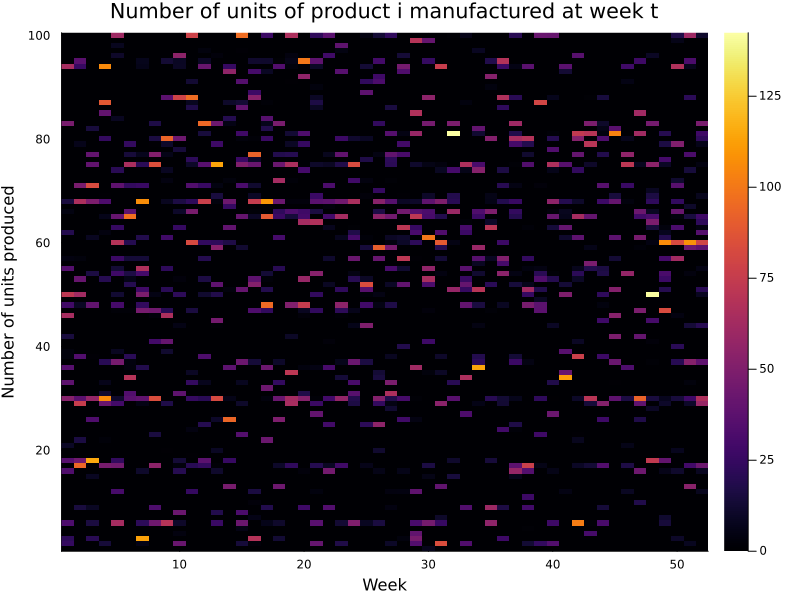

In [18]:
# Create a heatmap of (number of units of product i manufactured, week t)  and the 
heatmap(X_values, axis=true, color=:viridis, c=:auto, size=(800, 600), 
        xlabel="Week", ylabel="Number of units produced", title="Number of units of product i manufactured at week t")

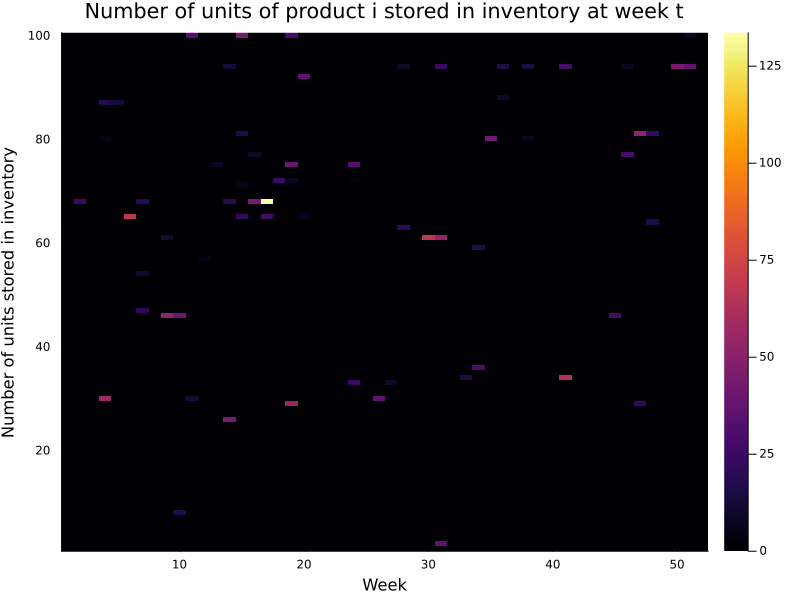

In [19]:
# Create a heatmap of (number of units of product i stored in inventory, week t)
heatmap(E_values, axis=true, color=:viridis, c=:auto, size=(800, 600), 
        xlabel="Week", ylabel="Number of units stored in inventory", title="Number of units of product i stored in inventory at week t")

Interpretation: 
- It makes sense to produce excess units of a product if there is unsatisfied demand some time in the future (that cannot be met by production at any later week), and net profit still exceeds the total holding cost.
- From the heatmap of excess units (holdings), we see that few products and weeks have positive holdings. This implies that the above condition is not met most of the time.


## 3(d)

In [20]:
week30_unused_materials = Vector{Float64}(undef, size(materials,1)) 
print("Materials fully utilized in week 30: ")
for j in materials
    week30_unused_materials[j] = A[j,30] - sum((R[j,i] * X_values[i,30]) for i in products)
    if abs(week30_unused_materials[j]) < 1e-10
        week30_unused_materials[j] = 0
        print(j, " ")
    end
end
println("\nNumber of materials fully utilized in week 30 (out of 500): ", count(x -> x == 0, week30_unused_materials))
println("Number of materials not fully utilized in week 30 (out of 500): ", count(x -> x > 0, week30_unused_materials))

Materials fully utilized in week 30: 16 31 42 48 64 101 105 117 141 157 190 201 274 302 307 322 331 354 387 388 
Number of materials fully utilized in week 30 (out of 500): 20
Number of materials not fully utilized in week 30 (out of 500): 480


In [21]:
week30_sold = X_values[:,30] + E_values[:,29] - E_values[:,30]
week30_demand = D[:,30]
week30_unfulfilled_demand = week30_demand - week30_sold
print("Products with demand fully satisfied in week 30: ")
for i in products
    if abs(week30_unfulfilled_demand[i]) < 1e-10
        week30_unfulfilled_demand[i] = 0
        print(i, " ")
    end
end
println("\nNumber of products with demand fully satisfied in week 30 (out of 100): ", count(x -> x == 0, week30_unfulfilled_demand))
println("Number of products with demand not fully satisfied in week 30 (out of 100): ", count(x -> x > 0, week30_unfulfilled_demand))

Products with demand fully satisfied in week 30: 61

 88 
Number of products with demand fully satisfied in week 30 (out of 100): 2
Number of products with demand not fully satisfied in week 30 (out of 100): 98
